In [8]:
!pip install --upgrade --force-reinstall --no-deps kaggle

  Using cached kaggle-1.5.12-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [9]:
# Make a directory named “.kaggle”
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [10]:
# Copy the “kaggle.json” into this new directory
! cp kaggle.json ~/.kaggle/

In [11]:
! chmod 600 ~/.kaggle/kaggle.json

In [12]:
! kaggle competitions download -c aptos2019-blindness-detection

100% 9.49G/9.51G [02:44<00:00, 90.4MB/s]
100% 9.51G/9.51G [02:44<00:00, 62.0MB/s]


In [13]:
! unzip aptos2019-blindness-detection.zip

Streaming output truncated to the last 5000 lines.
  inflating: test_images/512beaada8f0.png  
  inflating: test_images/51323e9d2070.png  
  inflating: test_images/515675001b9e.png  
  inflating: test_images/515877da2def.png  
  inflating: test_images/5168ddccea88.png  
  inflating: test_images/5172c056a687.png  
  inflating: test_images/5177461f5339.png  
  inflating: test_images/51910bcb980d.png  
  inflating: test_images/51a3e9b6a1c0.png  
  inflating: test_images/51bbd82feec8.png  
  inflating: test_images/51de5fb8eccd.png  
  inflating: test_images/51e88694c81f.png  
  inflating: test_images/51f0bf8f1544.png  
  inflating: test_images/51f57fb32840.png  
  inflating: test_images/51fa42dc1415.png  
  inflating: test_images/5276ab33b7b0.png  
  inflating: test_images/52a353760f72.png  
  inflating: test_images/531937254e73.png  
  inflating: test_images/5325b1c22c61.png  
  inflating: test_images/53959e0a750b.png  
  inflating: test_images/53be22c72713.png  
  inflating: test_images/

In [14]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # Plotting
import seaborn as sns # Plotting

# Import Image Libraries - Pillow and OpenCV
from PIL import Image
import cv2

# Import PyTorch and useful fuctions
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import torch.optim as optim
import torchvision.models as models # Pre-Trained models

# Import useful sklearn functions
import sklearn
from sklearn.metrics import cohen_kappa_score, accuracy_score

import time
import os
from tqdm import tqdm_notebook

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #Use GPU if it's available or else use CPU.
print(device) #Prints the device we're using.

data = pd.read_csv('train.csv')
print('Train Size = {}'.format(len(data)))
data.head()

cuda
Train Size = 3662


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


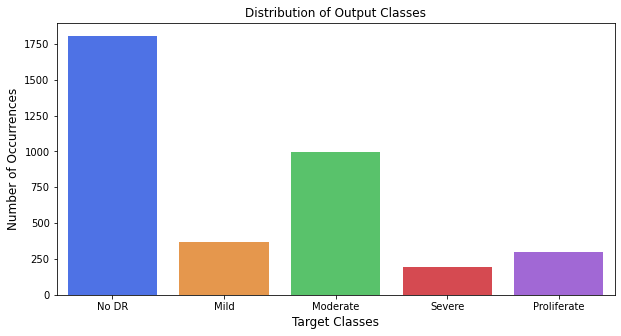

In [15]:
counts = data['diagnosis'].value_counts()
class_list = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferate']
for i,x in enumerate(class_list):
    counts[x] = counts.pop(i)

plt.figure(figsize=(10,5))
sns.barplot(x=counts.index, y=counts.values, alpha=0.8, palette='bright')
plt.title('Distribution of Output Classes')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Target Classes', fontsize=12)
plt.show()

In [16]:
#As you can see,the data is imbalanced.
#So we've to calculate weights for each class,which can be used in calculating loss.

from sklearn.utils import class_weight #For calculating weights for each class.
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.array([0,1,2,3,4]),y=data['diagnosis'].values)
class_weights = torch.tensor(class_weights,dtype=torch.float).to(device)
 
print(class_weights) #Prints the calculated weights for the classes.

tensor([0.4058, 1.9795, 0.7331, 3.7948, 2.4827], device='cuda:0')


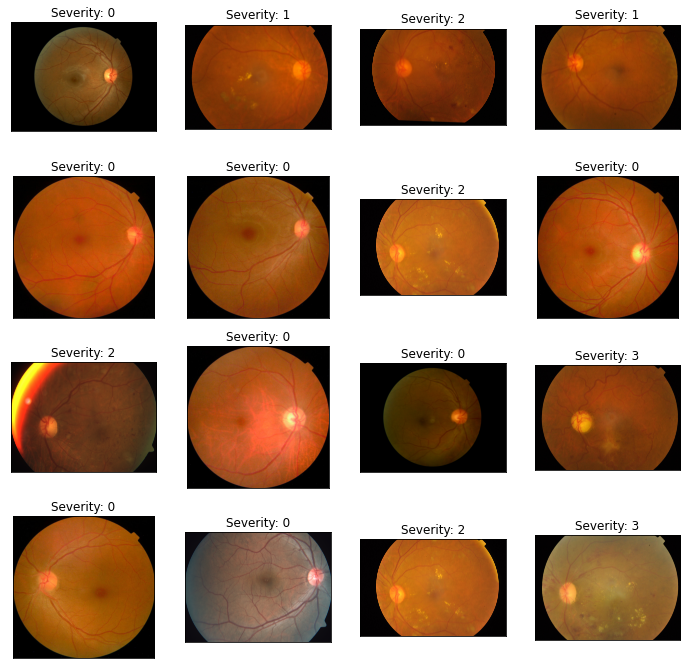

In [17]:
fig = plt.figure(figsize=(12, 12))
# display random 16 images
train_imgs = os.listdir("train_images")
for idx, img in enumerate(np.random.choice(train_imgs, 16)):
    ax = fig.add_subplot(4, 4, idx+1, xticks=[], yticks=[])
    im = Image.open("train_images/" + img)
    plt.imshow(im)
    lab = data.loc[data['id_code'] == img.split('.')[0], 'diagnosis'].values[0]
    ax.set_title('Severity: %s'%lab)

In [18]:
class dataset(Dataset): # Inherits from the Dataset class.
    '''
    dataset class overloads the __init__, __len__, __getitem__ methods of the Dataset class. 
    
    Attributes :
        df:  DataFrame object for the csv file.
        data_path: Location of the dataset.
        image_transform: Transformations to apply to the image.
        train: A boolean indicating whether it is a training_set or not.
    '''
    
    def __init__(self,df,data_path,image_transform=None,train=True): # Constructor.
        super(Dataset,self).__init__() #Calls the constructor of the Dataset class.
        self.df = df
        self.data_path = data_path
        self.image_transform = image_transform
        self.train = train
        
    def __len__(self):
        return len(self.df) #Returns the number of samples in the dataset.
    
    def __getitem__(self,index):
        image_id = self.df['id_code'][index]
        image = Image.open(f'{self.data_path}/{image_id}.png') #Image.
        if self.image_transform :
            image = self.image_transform(image) #Applies transformation to the image.
        
        if self.train :
            label = self.df['diagnosis'][index] #Label.
            return image,label #If train == True, return image & label.
        
        else:
            return image #If train != True, return image.

In [19]:
image_transform = transforms.Compose([transforms.Resize([512,512]),
                                      transforms.ToTensor(),
                                      torchvision.transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]) #Transformations to apply to the image.
data_set = dataset(data,f'train_images',image_transform=image_transform)

#Split the data_set so that valid_set contains 0.1 samples of the data_set. 
train_set,valid_set = torch.utils.data.random_split(data_set,[3100,562])

In [20]:
train_dataloader = DataLoader(train_set,batch_size=32,shuffle=True) #DataLoader for train_set.
valid_dataloader = DataLoader(valid_set,batch_size=32,shuffle=False) #DataLoader for validation_set.

In [21]:
#Since we've less data, we'll use Transfer learning.
model = models.resnet34(pretrained=True) #Downloads the resnet18 model which is pretrained on Imagenet dataset.

#Replace the Final layer of pretrained resnet18 with 4 new layers.
in_features = model.fc.in_features
print(in_features)
model.fc = nn.Sequential(nn.Linear(512,256), nn.Dropout(p=0.2), nn.Linear(256,128), nn.Dropout(p=0.5), nn.Linear(128,64), nn.Linear(64,5))

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

512


In [22]:
model = model.to(device) #Moves the model to the device.

In [23]:
def train(dataloader,model,loss_fn,optimizer):
    '''
    train function updates the weights of the model based on the
    loss using the optimizer in order to get a lower loss.
    
    Args :
         dataloader: Iterator for the batches in the data_set.
         model: Given an input produces an output by multiplying the input with the model weights.
         loss_fn: Calculates the discrepancy between the label & the model's predictions.
         optimizer: Updates the model weights.
         
    Returns :
         Average loss per batch which is calculated by dividing the losses for all the batches
         with the number of batches.
    '''

    model.train() #Sets the model for training.
    
    total = 0
    correct = 0
    running_loss = 0
    
    for batch,(x,y) in enumerate(dataloader): #Iterates through the batches.
        
        output = model(x.to(device)) #model's predictions.
        loss   = loss_fn(output,y.to(device)) #loss calculation.
       
        running_loss += loss.item()
        
        total        += y.size(0)
        predictions   = output.argmax(dim=1).cpu().detach() #Index for the highest score for all the samples in the batch.
        correct      += (predictions == y.cpu().detach()).sum().item() #No.of.cases where model's predictions are equal to the label.
        
        optimizer.zero_grad() #Gradient values are set to zero.
        loss.backward() #Calculates the gradients.
        optimizer.step() #Updates the model weights.
             
    
    avg_loss = running_loss/len(dataloader) # Average loss for a single batch
    avg_acc = 100*(correct/total)
    
    print(f'\nTraining Loss per batch = {avg_loss:.6f}',end='\t')
    print(f'Accuracy on Training set = {100*(correct/total):.6f}% [{correct}/{total}]') #Prints the Accuracy.
    
    return avg_loss, avg_acc

In [24]:
def validate(dataloader,model,loss_fn):
    '''
    validate function calculates the average loss per batch and the accuracy of the model's predictions.
    
    Args :
         dataloader: Iterator for the batches in the data_set.
         model: Given an input produces an output by multiplying the input with the model weights.
         loss_fn: Calculates the discrepancy between the label & the model's predictions.
    
    Returns :
         Average loss per batch which is calculated by dividing the losses for all the batches
         with the number of batches.
    '''
    
    model.eval() #Sets the model for evaluation.
    
    total = 0
    correct = 0
    running_loss = 0
    
    with torch.no_grad(): #No need to calculate the gradients.
        
        for x,y in dataloader:
            
            output        = model(x.to(device)) #model's output.
            loss          = loss_fn(output,y.to(device)).item() #loss calculation.
            running_loss += loss
            
            total        += y.size(0)
            predictions   = output.argmax(dim=1).cpu().detach()
            correct      += (predictions == y.cpu().detach()).sum().item()
            
    avg_loss = running_loss/len(dataloader) #Average loss per batch.  
    avg_acc = 100*(correct/total)
    
    print(f'\nValidation Loss per batch = {avg_loss:.6f}',end='\t')
    print(f'Accuracy on Validation set = {100*(correct/total):.6f}% [{correct}/{total}]') #Prints the Accuracy.
    
    return avg_loss, avg_acc

In [25]:
def optimize(train_dataloader,valid_dataloader,model,loss_fn,optimizer,nb_epochs):
    '''
    optimize function calls the train & validate functions for (nb_epochs) times.
    
    Args :
        train_dataloader: DataLoader for the train_set.
        valid_dataloader: DataLoader for the valid_set.
        model: Given an input produces an output by multiplying the input with the model weights.
        loss_fn: Calculates the discrepancy between the label & the model's predictions.
        optimizer: Updates the model weights.
        nb_epochs: Number of epochs.
        
    Returns :
        Tuple of lists containing losses for all the epochs.
    '''
    #Lists to store losses for all the epochs.
    train_losses = []
    valid_losses = []
    train_acc = []
    valid_acc = []

    for epoch in range(nb_epochs):
        print(f'\nEpoch {epoch+1}/{nb_epochs}')
        print('-------------------------------')
        train_loss, train_a = train(train_dataloader,model,loss_fn,optimizer) #Calls the train function.
        train_losses.append(train_loss)
        train_acc.append(train_a)
        valid_loss, valid_a = validate(valid_dataloader,model,loss_fn) #Calls the validate function.
        valid_losses.append(valid_loss)
        valid_acc.append(valid_a)
    
    print('\nTraining has completed!')
    return train_losses, valid_losses, train_acc, valid_acc
    

In [26]:
loss_fn   = nn.CrossEntropyLoss(weight=class_weights) #CrossEntropyLoss with class_weights.
optimizer = torch.optim.SGD(model.parameters(),lr=0.001) 
nb_epochs = 30
#Call the optimize function.
train_losses, valid_losses, train_acc, valid_acc = optimize(train_dataloader,valid_dataloader,model,loss_fn,optimizer,nb_epochs)


Epoch 1/30
-------------------------------

Training Loss per batch = 1.607310	Accuracy on Training set = 17.903226% [555/3100]

Validation Loss per batch = 1.585312	Accuracy on Validation set = 23.487544% [132/562]

Epoch 2/30
-------------------------------

Training Loss per batch = 1.576184	Accuracy on Training set = 30.290323% [939/3100]

Validation Loss per batch = 1.556761	Accuracy on Validation set = 55.693950% [313/562]

Epoch 3/30
-------------------------------

Training Loss per batch = 1.546983	Accuracy on Training set = 41.903226% [1299/3100]

Validation Loss per batch = 1.524738	Accuracy on Validation set = 59.786477% [336/562]

Epoch 4/30
-------------------------------

Training Loss per batch = 1.517596	Accuracy on Training set = 52.677419% [1633/3100]

Validation Loss per batch = 1.480091	Accuracy on Validation set = 60.320285% [339/562]

Epoch 5/30
-------------------------------

Training Loss per batch = 1.473519	Accuracy on Training set = 58.645161% [1818/3100]


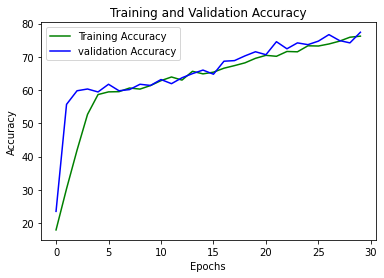

In [27]:
epochs = range(30)
plt.plot(epochs, train_acc, 'g', label='Training Accuracy')
plt.plot(epochs, valid_acc, 'b', label='validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

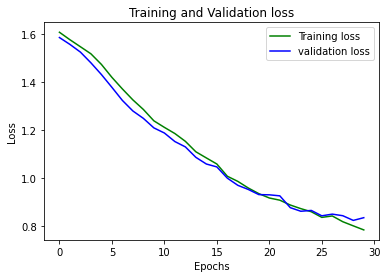

In [28]:
epochs = range(30)
plt.plot(epochs, train_losses, 'g', label='Training loss')
plt.plot(epochs, valid_losses, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [29]:
#model(data_set['x'])
model.eval()
results = []
# data_pred = dataset(data[:100], f'train_images',image_transform=image_transform)
i = 0
j = 0
k = 0
l = 0
m = 0
for x, y in DataLoader(data_set):
  if (y.numpy()[0] == 0 and i<20):
    result = model(x.to(device)).argmax(dim=1).cpu().detach()
    results.append((result.numpy()[0], y.numpy()[0]))
    i = i+1
  if (y.numpy()[0] == 1 and j<20):
    result = model(x.to(device)).argmax(dim=1).cpu().detach()
    results.append((result.numpy()[0], y.numpy()[0]))
    j = j+1
  if (y.numpy()[0] == 2 and k<20):
    result = model(x.to(device)).argmax(dim=1).cpu().detach()
    results.append((result.numpy()[0], y.numpy()[0]))
    k = k+1
  if (y.numpy()[0] == 3 and l<20):
    result = model(x.to(device)).argmax(dim=1).cpu().detach()
    results.append((result.numpy()[0], y.numpy()[0]))
    l = l+1
  if (y.numpy()[0] == 4 and m<20):
    result = model(x.to(device)).argmax(dim=1).cpu().detach()
    results.append((result.numpy()[0], y.numpy()[0]))
    m = m+1
  if(i+j+k+l+m >=100):
    break

In [30]:
i, j, k, l, m

(20, 20, 20, 20, 20)

In [31]:
from sklearn.metrics import confusion_matrix
import numpy as np

labelis = [val[1] for val in results]
predis = [val[0] for val in results]

cm = confusion_matrix(labelis, predis, labels=[0, 1, 2, 3, 4])
cm

array([[20,  0,  0,  0,  0],
       [ 1, 15,  2,  0,  2],
       [ 1,  6,  8,  0,  5],
       [ 0,  0,  3, 12,  5],
       [ 0,  2,  4,  4, 10]])

In [32]:
cm_df = pd.DataFrame(cm,
                     index = ['0','1','2', '3', '4'], 
                     columns = ['0','1','2', '3', '4'])
cm_df

,0,1,2,3,4
0,20,0,0,0,0
1,1,15,2,0,2
2,1,6,8,0,5
3,0,0,3,12,5
4,0,2,4,4,10


In [33]:
total = sum(cm_df.sum(axis=1))
total

100

In [34]:
arr = np.array(cm_df)
cnfm = []
for i in range(0,5):
  TP = arr[:][i][i]
  FN = sum(arr[:][i]) - arr[:][i][i]
  FP = cm_df.sum(axis=0)[i] - arr[:][i][i]
  TN = total - TP
  precision = TP /(TP+FP)
  recall  = TP/(TP+FN)
  f1 = 2*precision*recall/(precision+recall)
  cnfm.append([i, TP,FN,FP,TN, precision, recall, f1])
f1_result = pd.DataFrame(cnfm, columns = ['severity', 'True Positive','False Negative','False Positive', 'True Negative', 'Precision', 'Recall', 'F1-score'])
f1_result

,severity,True Positive,False Negative,False Positive,True Negative,Precision,Recall,F1-score
0,0,20,0,2,80,0.909091,1.00,0.952381
1,1,15,5,8,85,0.652174,0.75,0.697674
2,2,8,12,9,92,0.470588,0.40,0.432432
3,3,12,8,4,88,0.750000,0.60,0.666667
4,4,10,10,12,90,0.454545,0.50,0.476190


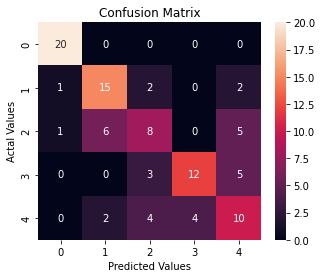

In [35]:
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [36]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score, auc

def test_class_probabilities(model, test_loader):
    model.eval()
    actuals = []
    probabilities = []
    i = 0
    j = 0
    k = 0
    l = 0
    f = 0
    with torch.no_grad():
        for x, y in test_loader:
          y = y.numpy()[0]
          outputs = model(x.to(device))
          prediction = outputs.argmax(dim=1, keepdim=True).cpu().detach()
          # if (prediction.numpy()[0] == y):
          if (y == 0 and i<10):
            actuals.append(y)
            values = outputs.cpu().detach().numpy()[0]
            m = -1*min(values)
            values = [val+m for val in values]
            prob = values/sum(values)
            probabilities.append(np.exp(prob))
            i = i+1
          if (y == 1 and j<10):
            actuals.append(y)
            values = outputs.cpu().detach().numpy()[0]
            m = -1*min(values)
            values = [val+m for val in values]
            prob = values/sum(values)
            probabilities.append(np.exp(prob))
            j = j+1
          if (y == 2 and k<10):
            actuals.append(y)
            values = outputs.cpu().detach().numpy()[0]
            m = -1*min(values)
            values = [val+m for val in values]
            prob = values/sum(values)
            probabilities.append(np.exp(prob))
            k = k+1
          if (y == 3 and l<10):
            actuals.append(y)
            values = outputs.cpu().detach().numpy()[0]
            m = -1*min(values)
            values = [val+m for val in values]
            prob = values/sum(values)
            probabilities.append(np.exp(prob))
            l = l+1
          if (y == 4 and f<10):
            actuals.append(y)
            values = outputs.cpu().detach().numpy()[0]
            m = -1*min(values)
            values = [val+m for val in values]
            prob = values/sum(values)
            probabilities.append(np.exp(prob))
            f = f+1
          if(i+j+k+l+f >=50):
            break
    return actuals,probabilities


def plot_roc( actuals,  probabilities):
    """
    compute ROC curve and ROC area for each class in each fold

    """
    fpr = {}
    tpr = {}
    thresh ={}
    roc_auc = {}
    n_class = 5

    for i in range(n_class):    
        fpr[i], tpr[i], thresh[i] = roc_curve(actuals, [val[i] for val in probabilities], pos_label=i)
        roc_auc[i] = auc(fpr[i], tpr[i])

        
    # plotting    
    plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label="Class 0 vs Rest (area = %0.2f)" % roc_auc[0])
    plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label="Class 1 vs Rest (area = %0.2f)" % roc_auc[1])
    plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label="Class 2 vs Rest (area = %0.2f)" % roc_auc[2])
    plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label="Class 3 vs Rest (area = %0.2f)" % roc_auc[3])
    plt.plot(fpr[3], tpr[3], linestyle='--',color='purple', label="Class 4 vs Rest (area = %0.2f)" % roc_auc[4])
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    plt.title('Multiclass ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')

In [37]:
act, prob = test_class_probabilities(model, DataLoader(data_set))

[2, 4, 1, 0, 0, 4, 0, 2, 2, 1, 0, 2, 0, 3, 1, 0, 2, 0, 0, 2, 2, 0, 1, 2, 0, 2, 4, 2, 4, 4, 4, 4, 1, 4, 3, 1, 3, 1, 1, 1, 3, 1, 3, 3, 4, 3, 4, 3, 3, 3]


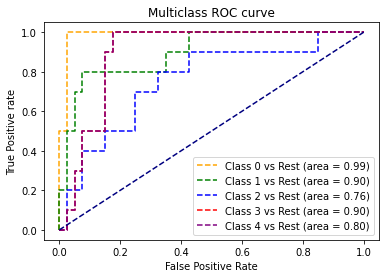

In [38]:
plot_roc(act, prob)
print(act)